# Analysis of the Spanish football league (La Liga)

The Spanish football league commonly known as La Liga is the first national football league in Spain, being one of the most popular professional sports leagues in the world. It was founded in 1929 and has been held every year since then with the exception of the period (1936–1939) due to the Spanish Civil War. At his foundation, it only consisted of 10 teams. Currently, it is made up of 20 teams quite evenly spread across the country but mainly from the most developed regions: Madrid, Barcelona, and Basque Country. The top four teams are qualified for the Champions League while the three lowest placed teams (positions 18–20) are relegated to the second division. As in most European countries, the winner of the game gets three points and both teams get 1 point if they draw.

This article is a journey through the history of the Spanish league. Analyzing historical data (all classifications from 1929 until 2020), we will be able to answer many questions about La Liga. What teams nearly won La Liga? Do referees favor Real Madrid and Barcelona? Is La Liga becoming too soft? When did Barcelona and Real Madrid's hegemony start? Since when is Barcelona catching up Real Madrid?

# Web data extraction

The historical data of La Liga (from 1929 until 2020) was scraped from www.bdfutbol.com. This website contains national and international football rankings. 
To scrape the data, we have used BeautifulSoup which is a popular Python library for extracting information from an HTML page. After obtaining all the data, we have stored it in a Pandas data frame for further processing.

In [130]:
import time

import requests
import bs4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

# the web page bdfutbol contains historical data about multiple european leagues - we have selected la liga española
web_page = 'https://www.bdfutbol.com/es/t/'
league = 't.html#primera'

# obtain the html code as a string
response = requests.get(web_page + league)
html = response.text

# create a BeautifulSoup object
soup = bs4.BeautifulSoup(html, "html.parser")
df_scores = pd.DataFrame()

# loop through the anchor tags
for anchor in soup.find(class_="bloc_temporades").find_all('a'):
    
    # get the hypertext reference and the text of the anchor tag
    page = anchor.get('href')
    season = anchor.text
    
    # obtain the html code as a string
    response = requests.get(web_page + page)
    html = response.text

    # create a BeautifulSoup object
    soup = bs4.BeautifulSoup(html, "html.parser")
    
    # obtain the table containing the annual classification
    table = soup.find(class_="taula_estil sortable")
    df_league = pd.read_html(str(table))[0]
    
    # add the season - anchor text and append the data frame to df_scores 
    df_league['season'] = season
    df_scores = df_scores.append(df_league)
    
    time.sleep(0.2)

# visualize the first five rows of the scraped data frame
df_scores.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Puntos,PJ,PG,PE,PP,GF,GC,TA,TR,season
0,1,NaN,Real Madrid,87,38,26,9,3,70,25,79,4,2019-20
1,2,NaN,Barcelona,82,38,25,7,6,86,38,89,6,2019-20
2,3,NaN,Atlético de Madrid,70,38,18,16,4,51,27,91,3,2019-20
3,4,NaN,Sevilla,70,38,19,13,6,54,34,97,1,2019-20
4,5,NaN,Villarreal,60,38,18,6,14,63,49,78,1,2019-20


# Data Cleaning

Data Cleaning is the process of transforming raw data into a standardized form that can easily be analyzed with data analytics tools.  In this particular case, before analyzing the data using Pandas, we have performed multiple cleaning operations. We have removed unnecessary columns and renamed the remaining ones using English terms (remember that data was scraped from a Spanish website). During the exploratory data analysis, we have noticed that in some cases multiple names were used to refer to the same football team. Over the years, some football teams have changed their names obligated in most cases by law. For instance, during the Spanish Second Republic (1931–1939) was not allowed to use the royal symbols. As a consequence, many football teams modified their names which contained the word 'Real' (Royal in English) to avoid being convicted for praising the monarchy. Real Madrid was not only renamed just Madrid but also lost the crown of his shield. Subsequently, during the Franco regime, they recovered the word 'Real', but a new law affected other team names. The dictatorship banned the use of foreign words from 1941  until 1972. Consequently, teams such as Athletic Club, Racing de Santander, and Sporting de Gijón were forced to modify their historical names for 30 years to Atlético de Bilbao, Santander, and Real Gijón.

### Drop unnecessary columns

In [131]:
# drop the column Unnamed:1 - this column does not contain valuable information
df_scores.drop(columns=['Unnamed: 1'], inplace=True)

In [132]:
# check that the modification has been carried out properly
df_scores.columns

Index(['Unnamed: 0', 'Unnamed: 2', 'Puntos', 'PJ', 'PG', 'PE', 'PP', 'GF',
       'GC', 'TA', 'TR', 'season'],
      dtype='object')

### Rename the columns using English terms

In [133]:
# rename the columns 
df_scores.rename({'Unnamed: 0': 'position', 'Unnamed: 2': 'club', 'Puntos': 'points', 'PJ': 'played', 'PG': 'won',
                  'PE': 'drawn', 'PP': 'lost', 'GF': 'goals_for', 'GC': 'goals_against', 'TA': 'yellow_card',
                  'TR': 'red_card'}, axis=1, inplace=True)

In [134]:
# check that the modification has been carried out properly
df_scores.columns

Index(['position', 'club', 'points', 'played', 'won', 'drawn', 'lost',
       'goals_for', 'goals_against', 'yellow_card', 'red_card', 'season'],
      dtype='object')

### Remove old club names

In [135]:
# mapping dictionary - the keys contain old club names and the values are current club names
old_club_names = {'Unión Irún': 'Real Unión', 'Donostia': 'Real Sociedad', 'Athletic de Madrid': 'Atlético de Madrid',
                  'Madrid': 'Real Madrid', 'Alicante CD': 'Hércules', 'Atlético Aviación': 'Atlético de Madrid',
                  'Gimnástico de Tarragona': 'Gimnàstic de Tarragona', 'Lérida': 'Lleida', 'Santander': 'Racing de Santander',
                  'Real Gijón': 'Sporting de Gijón', 'Atlético de Bilbao': 'Athletic Club', 'CD Málaga': 'Málaga',
                  'Español': 'Espanyol'}

# replace old club denominations by current denominations
df_scores.replace(old_club_names, inplace=True)

In [136]:
# check that the modification has been carried out properly 
df_scores.club.unique()

array(['Real Madrid', 'Barcelona', 'Atlético de Madrid', 'Sevilla',
       'Villarreal', 'Real Sociedad', 'Granada', 'Getafe', 'Valencia',
       'Osasuna', 'Athletic Club', 'Levante', 'Valladolid', 'Eibar',
       'Betis', 'Alavés', 'Celta de Vigo', 'Leganés', 'Mallorca',
       'Espanyol', 'Girona', 'Huesca', 'Rayo Vallecano',
       'Deportivo de La Coruña', 'Las Palmas', 'Málaga',
       'Sporting de Gijón', 'Elche', 'Almería', 'Córdoba', 'Zaragoza',
       'Racing de Santander', 'Hércules', 'Tenerife', 'Xerez', 'Numancia',
       'Recreativo de Huelva', 'Murcia', 'Gimnàstic de Tarragona',
       'Cádiz', 'Albacete', 'Oviedo', 'Extremadura', 'Salamanca',
       'Compostela', 'Mérida', 'Logroñés', 'Lleida', 'Real Burgos',
       'Castellón', 'Sabadell', 'AD Almería', 'Burgos', 'Pontevedra',
       'Jaén', 'Condal', 'Cultural Leonesa', 'Atlético Tetuán',
       'Alcoyano', 'Arenas de Guecho', 'Real Unión', 'Europa'],
      dtype=object)

### Modify incorrect data types

In [137]:
# during one season the spanish league was divided into 3 groups that is why the position is indicated with letters and numbers
position_letters = ['A-1', 'A-2', 'A-3', 'A-4', 'A-5', 'A-6', 'B-1', 'B-2', 'B-3', 'B-4', 'B-5', 'B-6', 'C-1', 'C-2', 'C-3',
            'C-4', 'C-5', 'C-6']
position_numbers = list(range(1,19))

# replace this notation (letters+numbers) with numbers
df_scores.position.replace(position_letters, position_numbers, inplace=True)

In [138]:
# check that the modification has been carried out properly
df_scores.position.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22], dtype=int64)

In [139]:
# in some cases the entries in the column (points) contain additional symbols
df_scores.points = df_scores.points.astype(str)

# remove the symbols extracting only the digits
df_scores.points = df_scores.points.str.extract('(\d+)')

In [140]:
# check that the modification has been carried out properly
df_scores.position.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22], dtype=int64)

In [141]:
# convert both columns into int data types
df_scores.points = df_scores.points.astype(int)
df_scores.position = df_scores.position.astype(int)

In [142]:
# check that the modification has been carried out properly
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522 entries, 0 to 9
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   position       1522 non-null   int32 
 1   club           1522 non-null   object
 2   points         1522 non-null   int32 
 3   played         1522 non-null   int64 
 4   won            1522 non-null   int64 
 5   drawn          1522 non-null   int64 
 6   lost           1522 non-null   int64 
 7   goals_for      1522 non-null   int64 
 8   goals_against  1522 non-null   int64 
 9   yellow_card    1522 non-null   int64 
 10  red_card       1522 non-null   int64 
 11  season         1522 non-null   object
dtypes: int32(2), int64(8), object(2)
memory usage: 142.7+ KB


# Spanish league winners
The Spanish league has been played by more of 60 different clubs; however, only nine of them got their hands on the trophy. The following plot shows the Spanish league winners from season 1928–29 until 2019–20.

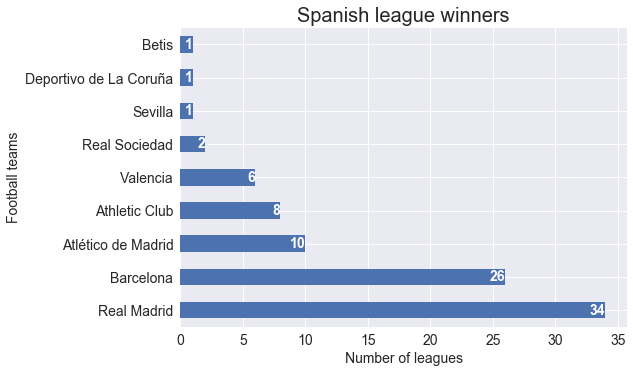

In [143]:
# teams that won la liga española
first_position = df_scores[df_scores['position'] == 1].club.value_counts()

# plot labels indicating the number of leagues
for i, value in enumerate(first_position):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=14)

# plot the results using an horizontal bar plot
first_position.plot(kind='barh')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Number of leagues', fontsize=14)
plt.ylabel('Football teams', fontsize=14)
plt.title('Spanish league winners', fontsize=20);

As shown above, Real Madrid is the most successful club in the history of La Liga with 34 titles followed by Barcelona with 26 leagues. However, as we will see later, Barcelona is catching up. Apart from these two clubs, the Spanish first division has been won by other 7 clubs, including Atlético Madrid (10), Athletic Club (8), Valencia (6), Real Sociedad (2), Betis (1), Sevilla (1), and Deportivo de La Coruña (1).

# Spanish league runner-ups
It is heartbreaking to be a runner-up. For Real Madrid and Barcelona to be second is a shameful failure that could easily end up with the dismissal of the coach or with multiple multi-millionaire signings for the next season. For other teams, it is just a dream that almost comes true, but definitely not a failure. Failure, after all, is just a matter of expectations.

As shown below, there are 5 football teams that have never won the league but they were on one occasion runner-ups: Racing de Santander (1930–31), Las Palmas (1968–69), Zaragoza (1974–75), Sporting de Gijón (1978–79), and Villarreal (2007–08). Additionally, we can also observe that Barcelona has been on more occasions runner-up of La Liga than Real Madrid.

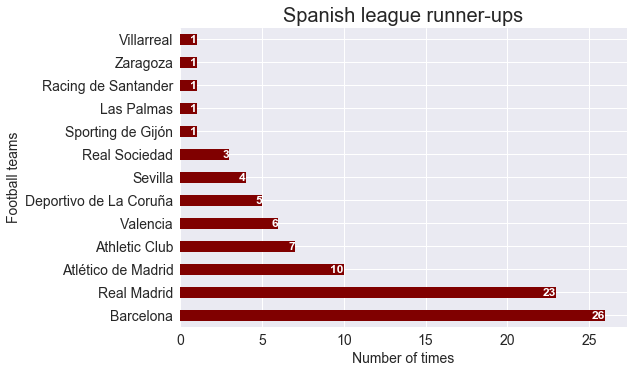

In [144]:
# spanish league runner-ups
second_position = df_scores[df_scores['position'] == 2].club.value_counts()

# plot labels indicating the number times the team was runner-up
for i, value in enumerate(second_position):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=12)

# plot the results using an horizontal bar plot
second_position.plot(kind='barh', color='maroon')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Number of times', fontsize=14)
plt.ylabel('Football teams', fontsize=14)
plt.title('Spanish league runner-ups', fontsize=20);

In [145]:
# years in which Racing de Santander, Villarreal, Las Palmas, Zaragoza, and Sporting de Gijón were runner-ups
teams = ['Racing de Santander', 'Villarreal', 'Las Palmas', 'Zaragoza', 'Sporting de Gijón']

df_scores[(df_scores['position'] == 2) & (df_scores['club'].isin(teams))]

,position,club,points,played,won,drawn,lost,goals_for,goals_against,yellow_card,red_card,season
1,2,Villarreal,77,38,24,5,9,63,40,88,3,2007-08
1,2,Sporting de Gijón,43,34,17,9,8,50,35,21,1,1978-79
1,2,Zaragoza,38,34,15,8,11,58,47,29,1,1974-75
1,2,Las Palmas,38,30,15,8,7,45,34,0,1,1968-69
1,2,Racing de Santander,22,18,10,2,6,49,37,0,0,1930-31


# Total number of seasons in the first division (Top 10)
There are only 3 football teams that have never been relegated to the second division: Athletic Club, Barcelona, and Real Madrid. Espanyol and Valencia played 4 seasons in the second division, and Atlético de Madrid 6.

All teams from the image below are currently in the first division with the exception of Zaragoza (since 2012–13 in the second division).

Text(0, 0.5, 'Number of seasons')

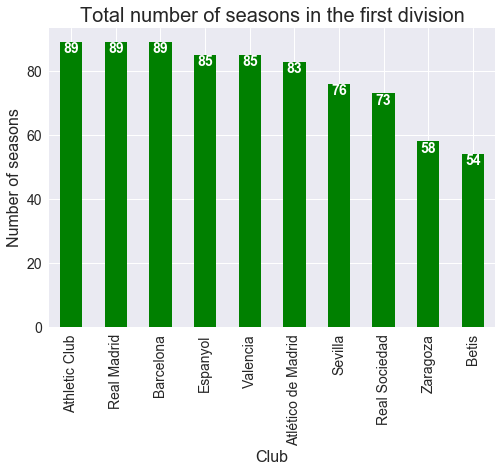

In [146]:
# total number of seasons in the first division (top 10)
number_of_seasons = df_scores.groupby('club').count().position.sort_values(ascending=False).head(10)

# plot labels indicating the number of seasons in the first division
for i,value in enumerate(number_of_seasons):
     plt.text(i, value, str(value), horizontalalignment='center',verticalalignment='top', weight='bold', color='white', fontsize=14)

# plot the results using an horizontal bar plot
number_of_seasons.plot(kind='bar', color='green')

# modify the ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Total number of seasons in the first division', fontsize=20)
plt.xlabel('Club', fontsize=16)
plt.ylabel('Number of seasons', fontsize=16)

# Number of teams in the Spanish league per season
The number of teams in La Liga has steadily increased from 10 to 20 teams with the exception of the seasons 1995–96 and 1996–97, during which 22 teams played.

Currently, 20 teams play the Spanish league. The same number of teams play the Serie A (Italy), the Ligue 1 (France), and the Premier League (England). On the contrary, 18 teams take part in the Bundesliga (Germany), the Primeira Liga (Portugal), and the Eredivisie (Holand).Evolution of the number of leagues

Text(0, 0.5, 'Number of clubs')

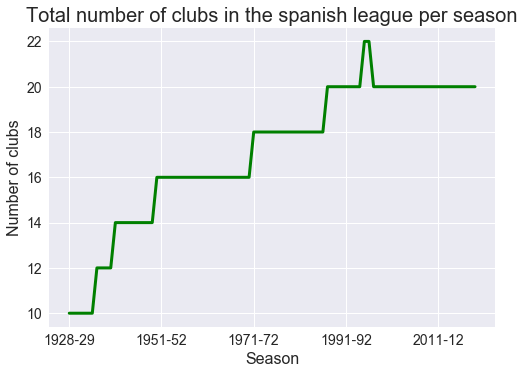

In [147]:
# number of teams in the Spanish league per season
number_clubs = df_scores.groupby('season').count().club

# plot the results using a line plot
number_clubs.plot(linewidth=3, color='g')

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Total number of clubs in the spanish league per season', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Number of clubs', fontsize=16)

# Evolution of the number of leagues
It is said in Spain that La Liga is played by two teams the rest is ornamentation and in my opinion, that is totally true 😢. Since 2000, Real Madrid and Barcelona have won 17 out of 20 leagues, being for other teams almost impossible to compete against them. But has always been the Spanish league that boring? Has always been dominated by Madrid or Barcelona? When did the Real Madrid and Barcelona's hegemony begin? Let's clarify all questions with a simple plot. 

The following plot shows the evolution of the number of leagues by team.

In [148]:
# get a table were the winner is indicated with a 1 and the rest with a zero
winner_season = pd.get_dummies(df_scores[df_scores['position'] == 1][['club', 'season']], columns=['club'], prefix='', prefix_sep='')

winner_season

,season,Athletic Club,Atlético de Madrid,Barcelona,Betis,Deportivo de La Coruña,Real Madrid,Real Sociedad,Sevilla,Valencia
0,2019-20,0,0,0,0,0,1,0,0,0
0,2018-19,0,0,1,0,0,0,0,0,0
0,2017-18,0,0,1,0,0,0,0,0,0
0,2016-17,0,0,0,0,0,1,0,0,0
0,2015-16,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
0,1932-33,0,0,0,0,0,1,0,0,0
0,1931-32,0,0,0,0,0,1,0,0,0
0,1930-31,1,0,0,0,0,0,0,0,0
0,1929-30,1,0,0,0,0,0,0,0,0


In [149]:
# set season as index of the data frame
winner_season.set_index('season', inplace=True)

winner_season

,Athletic Club,Atlético de Madrid,Barcelona,Betis,Deportivo de La Coruña,Real Madrid,Real Sociedad,Sevilla,Valencia
season,,,,,,,,,
2019-20,0,0,0,0,0,1,0,0,0
2018-19,0,0,1,0,0,0,0,0,0
2017-18,0,0,1,0,0,0,0,0,0
2016-17,0,0,0,0,0,1,0,0,0
2015-16,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1932-33,0,0,0,0,0,1,0,0,0
1931-32,0,0,0,0,0,1,0,0,0
1930-31,1,0,0,0,0,0,0,0,0


In [150]:
# (1) transpose the data frame (first row - first season),(2) do a cumulative sum to obtain the evolution of the number of leagues
evolution_leagues = winner_season.loc[::-1].cumsum()

evolution_leagues.head(10)

,Athletic Club,Atlético de Madrid,Barcelona,Betis,Deportivo de La Coruña,Real Madrid,Real Sociedad,Sevilla,Valencia
season,,,,,,,,,
1928-29,0,0,1,0,0,0,0,0,0
1929-30,1,0,1,0,0,0,0,0,0
1930-31,2,0,1,0,0,0,0,0,0
1931-32,2,0,1,0,0,1,0,0,0
1932-33,2,0,1,0,0,2,0,0,0
1933-34,3,0,1,0,0,2,0,0,0
1934-35,3,0,1,1,0,2,0,0,0
1935-36,4,0,1,1,0,2,0,0,0
1939-40,4,1,1,1,0,2,0,0,0


Text(0, 0.5, 'Number of leagues')

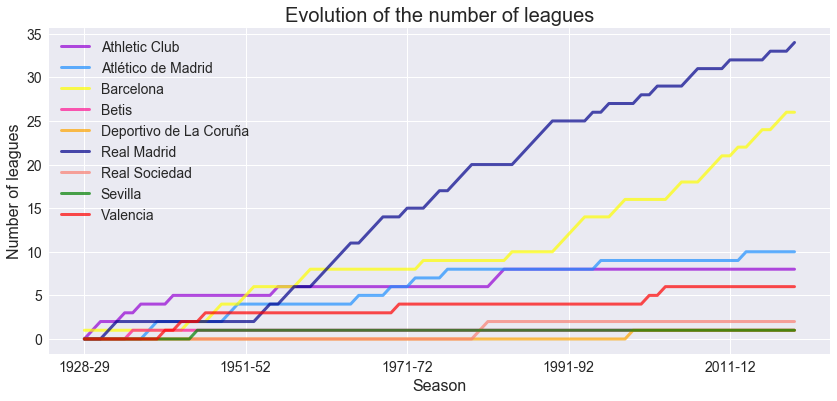

In [151]:
# colors for the plot
colors = ['darkviolet', 'dodgerblue', 'yellow', 'deeppink', 'orange', 'darkblue', 'salmon', 'green', 'red']

# plot the result using a line plot
evolution_leagues.plot(color=colors, alpha=0.7, linewidth=3, figsize=(14,6))

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# define the title and the labels
plt.title('Evolution of the number of leagues', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Number of leagues', fontsize=16)

As shown in the plot, in the first years of the league, although we can observe the slight prominence of Athletic Club, La Liga was not as hegemonic as it is nowadays and it was not clearly dominated by any club. In the late fifties, we start to see the beginning of Real Madrid's dominance with the signing of Di Stefano. The Argentinean completely changed the fate of Real Madrid which at that time was an average team and had not won the league in 20 years.

From the 1960s onward, Real Madrid took control over the league winning 14 titles in only two decades. At the time, 'El Clásico' was the match between Atlético de Madrid and Real Madrid since Atlético de Madrid was the only serious rival of The Meringues winning 4 leagues between 1960 and 1980. 

From the nineties onwards, Barcelona has dominated the Spanish league winning 16 titles. In the 1990s, under the supervision of Johan Cruyff (1988–1996), Barcelona ended with the overwhelming dominance of Real Madrid in the last years. Johan Cruyff created a possession-based football style that continued to be imitated by Barcelona's subsequent coaches, Louis Van Gaal, Frank Rijkaard, and particularly Guardiola. From the 2000s on, the hegemony of Barcelona continued powered by home-grown players such as Messi, Iniesta, Xavi, Busquets, Puyol or Pique. 

All the aforesaid can also be observed in the following plot which shows the number of leagues by team and decade.

In [152]:
# new column indicating the decade
# create a mapping dictionary 
years = list(range(1920,2021))

decades = []
for decade in range(1920,2030,10):
    decades.extend([decade]*10)

mapping = dict()
for year, decade in zip(years,decades):
    key = str(year) + '-' + str(year+1)[-2:]
    value = str(decade) + '-' + str(decade+10)
    mapping[key] = value 

# mapping dictionary 
print(mapping)

{'1920-21': '1920-1930', '1921-22': '1920-1930', '1922-23': '1920-1930', '1923-24': '1920-1930', '1924-25': '1920-1930', '1925-26': '1920-1930', '1926-27': '1920-1930', '1927-28': '1920-1930', '1928-29': '1920-1930', '1929-30': '1920-1930', '1930-31': '1930-1940', '1931-32': '1930-1940', '1932-33': '1930-1940', '1933-34': '1930-1940', '1934-35': '1930-1940', '1935-36': '1930-1940', '1936-37': '1930-1940', '1937-38': '1930-1940', '1938-39': '1930-1940', '1939-40': '1930-1940', '1940-41': '1940-1950', '1941-42': '1940-1950', '1942-43': '1940-1950', '1943-44': '1940-1950', '1944-45': '1940-1950', '1945-46': '1940-1950', '1946-47': '1940-1950', '1947-48': '1940-1950', '1948-49': '1940-1950', '1949-50': '1940-1950', '1950-51': '1950-1960', '1951-52': '1950-1960', '1952-53': '1950-1960', '1953-54': '1950-1960', '1954-55': '1950-1960', '1955-56': '1950-1960', '1956-57': '1950-1960', '1957-58': '1950-1960', '1958-59': '1950-1960', '1959-60': '1950-1960', '1960-61': '1960-1970', '1961-62': '196

In [153]:
# use the dictionary to create a new column indicating the decade
df_scores['decade']= df_scores.season.map(mapping)

# check that the modification has been carried out properly
df_scores.head()

,position,club,points,played,won,drawn,lost,goals_for,goals_against,yellow_card,red_card,season,decade
0,1,Real Madrid,87,38,26,9,3,70,25,79,4,2019-20,2010-2020
1,2,Barcelona,82,38,25,7,6,86,38,89,6,2019-20,2010-2020
2,3,Atlético de Madrid,70,38,18,16,4,51,27,91,3,2019-20,2010-2020
3,4,Sevilla,70,38,19,13,6,54,34,97,1,2019-20,2010-2020
4,5,Villarreal,60,38,18,6,14,63,49,78,1,2019-20,2010-2020


In [154]:
# number of leagues by decade and club - the indeces contain the decades and the columns contain the clubs
evolution_decades = df_scores[df_scores['position'] == 1].groupby(['decade', 'club']).count().position.unstack()

evolution_decades

club,Athletic Club,Atlético de Madrid,Barcelona,Betis,Deportivo de La Coruña,Real Madrid,Real Sociedad,Sevilla,Valencia
decade,,,,,,,,,
1920-1930,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1930-1940,3.0,1.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN
1940-1950,1.0,2.0,3.0,NaN,NaN,NaN,NaN,1.0,3.0
1950-1960,1.0,1.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN
1960-1970,NaN,2.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN
1970-1980,NaN,2.0,1.0,NaN,NaN,6.0,NaN,NaN,1.0
1980-1990,2.0,NaN,1.0,NaN,NaN,5.0,2.0,NaN,NaN
1990-2000,NaN,1.0,6.0,NaN,1.0,2.0,NaN,NaN,NaN
2000-2010,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,2.0


Text(0, 0.5, 'Number of leagues')

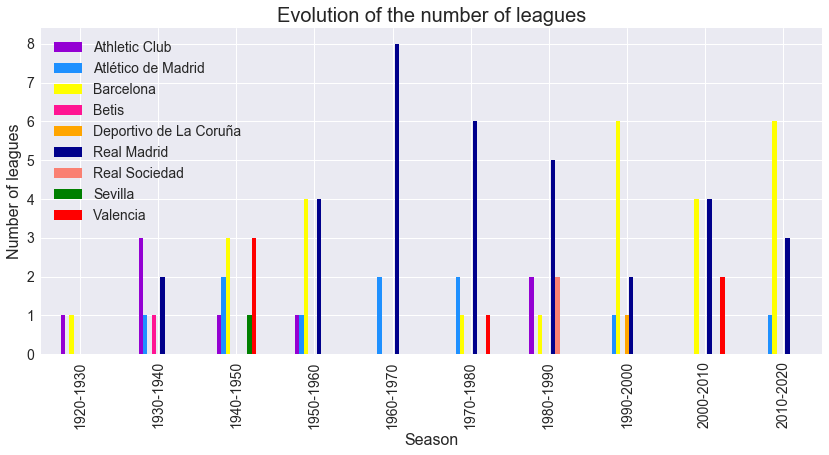

In [155]:
colors = ['darkviolet', 'dodgerblue', 'yellow', 'deeppink', 'orange', 'darkblue', 'salmon', 'green', 'red']

# plot the results using a bar plot
evolution_decades.plot(kind='bar', figsize=(14,6), color=colors)

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# define the title and the labels
plt.title('Evolution of the number of leagues', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Number of leagues', fontsize=16)

# The difference in leagues between Real Madrid and Barcelona
The following plot shows the difference in leagues between Real Madrid and Barcelona over time. As shown below, the maximum difference in favor of Barcelona was in the season 1952–1953. At that time, Barcelona had 4 leagues more than Real Madrid. However, in the mid-fifties, the luck of Real Madrid was about to change. From this time until the nineties, Real Madrid clearly dominated La Liga and the difference in leagues between The Blancos and Barcelona was increasing over time reaching its maximum in the season 1989–90 (15 leagues). From the 1990s onward, we observe how the difference in leagues is decreasing over time as a consequence of Barcelona's hegemony. Currently, Real Madrid has 8 leagues more than Barcelona.

In [156]:
# data frame containing the evolution of leagues of Real Madrid and Barcelona
real_vs_barcelona = evolution_leagues[['Real Madrid', 'Barcelona']].astype(float)

# difference = number of leagues of real - number of leagues of barcelona
difference = real_vs_barcelona['Real Madrid'] - real_vs_barcelona['Barcelona']

difference

season
1928-29   -1.0
1929-30   -1.0
1930-31   -1.0
1931-32    0.0
1932-33    1.0
          ... 
2015-16    8.0
2016-17    9.0
2017-18    8.0
2018-19    7.0
2019-20    8.0
Length: 89, dtype: float64

Text(0, 0.5, 'Difference of leagues')

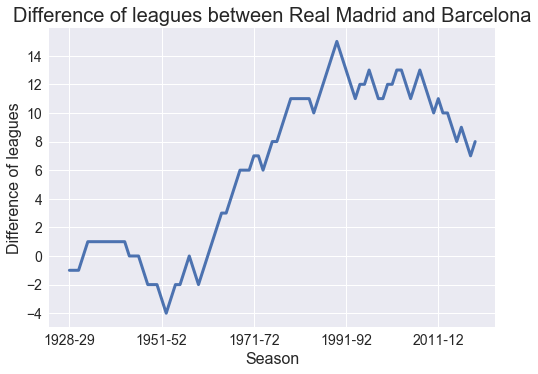

In [157]:
# plot the result using a line plot
difference.plot(linewidth=3)

# modify the ticks 
plt.xticks(fontsize=14)
plt.yticks(np.arange(-4, 16, 2), fontsize=14)

# define the title and the labels
plt.title('Difference of leagues between Real Madrid and Barcelona', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Difference of leagues', fontsize=16)

In [158]:
# maximum difference in favor of Real Madrid
difference[difference == difference.max()]

season
1989-90    15.0
dtype: float64

In [159]:
# maximum difference in favor of Barcelona
difference[difference == difference.min()]

season
1952-53   -4.0
dtype: float64

# Yellow and red cards in La Liga
There is one thing that most football fans across the world take for granted: the use cards. However, it was not until 1970 at the World Cup in Mexico that the yellow and red card system was used for the first time in football. The system was invented in 1966 by the English referee Ken Aston who noticed that many times football players did not understand or just ignored the warnings made by referees which at the time were orally communicated. Then, inspired by the colors of the traffic lights (red and yellow) and their meanings, Aston created a color-coding scheme to clearly indicate that a football player has been cautioned or expelled.

But as Hemingway said, Spain is different. The Spanish National team did not take part at the 1970 World Cup in Mexico where the card system was first used. The Spanish Federation of football thought that yellow cards were actually white so that is how they looked like in black and white TVs of the time. In January 1971 red and white cards were introduced in the Spanish League until 1976 when ýellow cards finally replaced white cards. 

The following plot shows the total number of red cards per season. As I previously said, before the year 1971, the referee announced to the player his fines verbally. In the figure below, prior to 1971, red cards represent football players that were expelled during the match only with words (without using cards).

Text(0, 0.5, 'Total number of red cards')

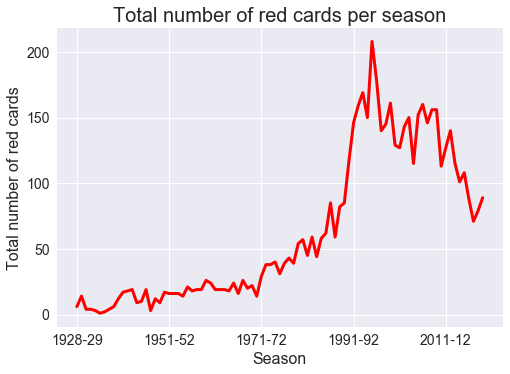

In [160]:
# number of red cards per season
red_cards = df_scores.groupby('season').sum().red_card

# plot the results using a line plot
red_cards.plot(linewidth=3, color='r')

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Total number of red cards per season', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Total number of red cards', fontsize=16)

We observe a growing tendency until the mid-nineties. From that moment on, the total amount of red cards is steadily decreasing over time. 
Likewise, the plot below shows the total number of yellow cards (including white cards) per season.

Text(0, 0.5, 'Total number of yellow cards')

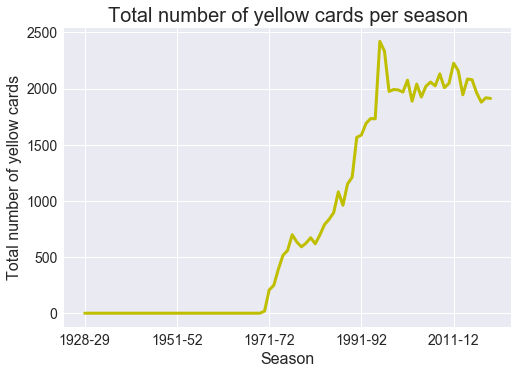

In [161]:
# number of yellow cards per season
yellow_cards = df_scores.groupby('season').sum().yellow_card

# plot the results using a line plot
yellow_cards.plot(linewidth=3, color='y')

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Total number of yellow cards per season', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Total number of yellow cards', fontsize=16)

The total number of yellow cards per season has grown steadily from 1971 until the mid-nineties. From this time on, the number of cards remains nearly constant around 2000 cards per season.

Prior to the use of cards, players often did not receive penalties. Only in special cases (really strong fouls), football players were expelled from the game. 

In Spain, it is said that referees favor Real Madrid and Barcelona in the last years. But is that really true? Let's see the numbers :)

The following plots show the average number of red and yellow cards by team from 1990 until 2020. As said, Real Madrid and Barcelona received on average fewer cards than other strong teams such as Atlético de Madrid, Valencia, Sevilla, or Athletic Club. Maybe their success is not only a combination of money and good players but also a little bit of help 😆

Text(0, 0.5, 'Average number of yellow cards')

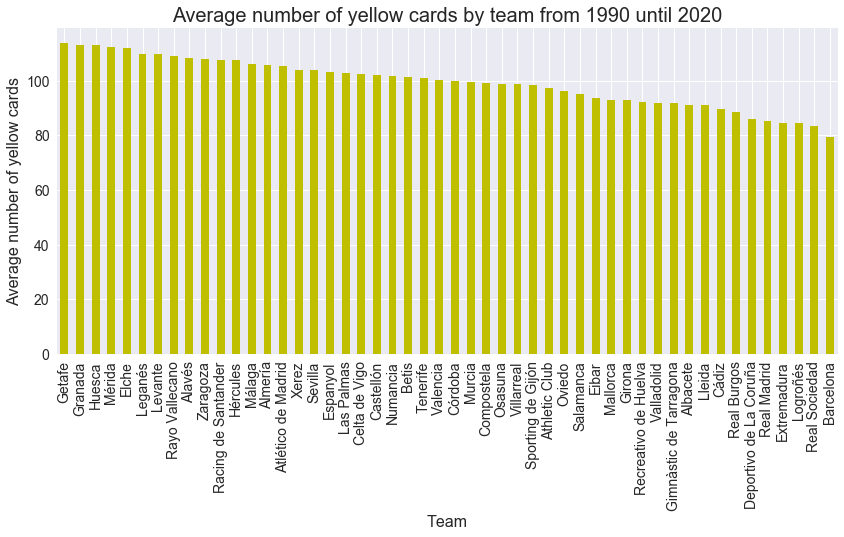

In [162]:
# average number of yellow cards by team from 1990 until 2020
yellow_from_1990 = df_scores[df_scores['season']>='1990-91'].groupby('club').mean().yellow_card.sort_values(ascending=False)

# plot the results using a bar plot
yellow_from_1990.plot(kind='bar', color='y', figsize=(14,6))

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Average number of yellow cards by team from 1990 until 2020', fontsize=20)
plt.xlabel('Team', fontsize=16)
plt.ylabel('Average number of yellow cards', fontsize=16)

Text(0, 0.5, 'Average number of red cards')

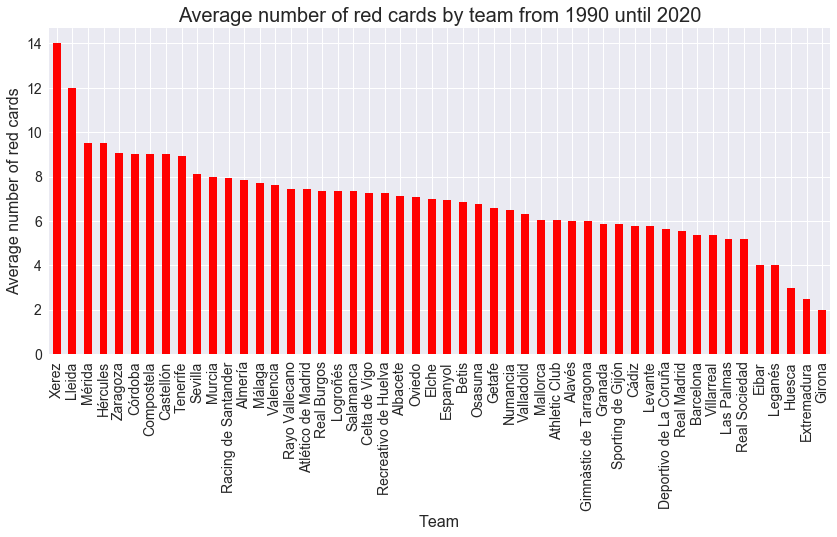

In [163]:
# average number of red cards by team from 1990 until 2020
red_from_1990 = df_scores[df_scores['season']>='1990-91'].groupby('club').mean().red_card.sort_values(ascending=False)

# plot the results using a bar plot 
red_from_1990.plot(kind='bar', color='r', figsize=(14,6))

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Average number of red cards by team from 1990 until 2020', fontsize=20)
plt.xlabel('Team', fontsize=16)
plt.ylabel('Average number of red cards', fontsize=16)

# Performance in the last 10 years 
The following plots show the performance of Valencia, Real Madrid, Barcelona, Atlético de Madrid, and Athletic Club in the last 10 years. As shown below, Real Madrid and Barcelona score on average more goals than the other teams.

Text(0, 0.5, 'Goals')

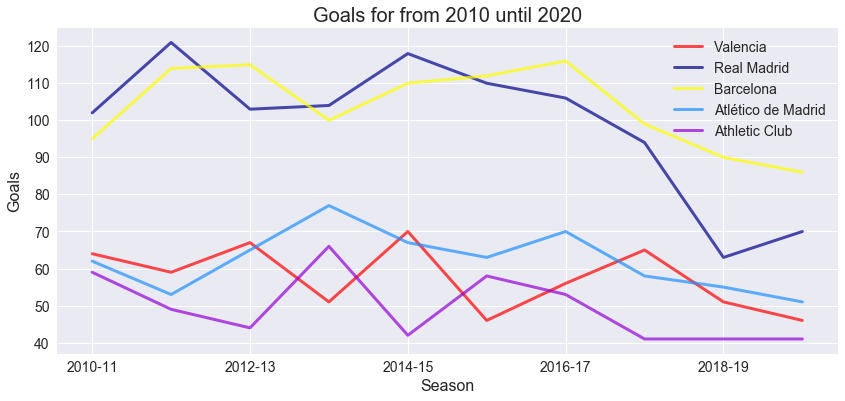

In [164]:
# data frame containing the goals for 
goals_for = df_scores.pivot(index='season', columns='club', values='goals_for')

# select the data from season 2010
seasons = ['2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
teams = ['Valencia', 'Real Madrid', 'Barcelona', 'Atlético de Madrid', 'Athletic Club']

# plot the results using a line plot
colors = ['red', 'darkblue', 'yellow',  'dodgerblue', 'darkviolet']
goals_for.loc[seasons, teams].plot(alpha=0.7, linewidth=3, color=colors, figsize=(14,6))

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='upper right')

# define the title and the labels
plt.title('Goals for from 2010 until 2020', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Goals', fontsize=16)

However, if we analyze the goals against, we observe that Atlético de Madrid is defensively the strongest team, even better than Barcelona, and the person responsible for all of this is Diego Simeone.

Text(0, 0.5, 'Goals')

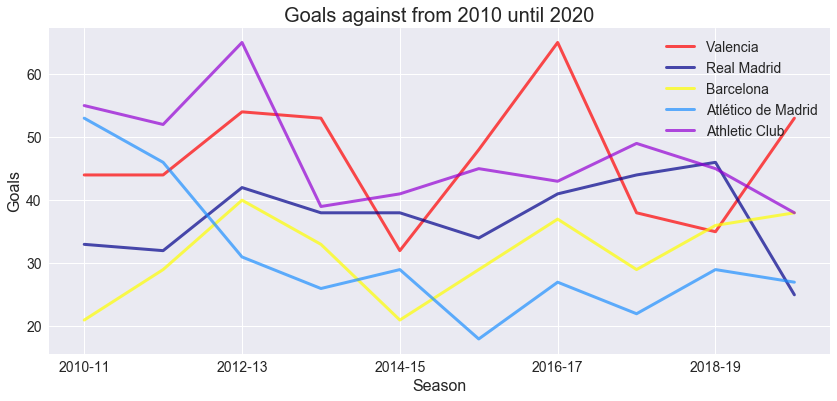

In [165]:
# data frame containing the goals against 
goals_against = df_scores.pivot(index='season', columns='club', values='goals_against')

# select the data from season 2010
seasons = ['2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
teams = ['Valencia', 'Real Madrid', 'Barcelona', 'Atlético de Madrid', 'Athletic Club']

# plot the results using a line plot
colors = ['red', 'darkblue', 'yellow',  'dodgerblue', 'darkviolet']
goals_against.loc[seasons, teams].plot(alpha=0.7, linewidth=3, color=colors, figsize=(14,6))

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='upper right')

# define the title and the labels
plt.title('Goals against from 2010 until 2020', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Goals', fontsize=16)

The Argentinean is the manager of Atlético de Madrid since December 2011. Under his supervision, Atletico de Madrid has developed a distinct identity based on a strong defensive style. With Diego Simeone as coach, Atlético de Madrid has won La Liga, La Copa del Rey, the  Europa League twice, and the UEFA Super Cup also twice, currently being the only serious rival of Real Madrid and Barcelona.

# Summary
The Spanish league has been clearly dominated by Real Madrid and Barcelona for a long time. In the beginning, the league was not as hegemonic as it is today and it was not clearly dominated by any club. From the mid-fifties on, Real Madrid took control over the league, being Atlético de Madrid his only serious rival. In the season 1989–90, Real Madrid had 15 leagues more than Barcelona. However, in the 90s, under the supervision of Johan Cruyff, Barcelona ended with the overwhelming dominance of Real Madrid. From that time on, the difference in leagues between them is gradually decreasing. Nowadays, Real Madrid and particularly Barcelona clearly dominate La Liga, being really hard for other teams to compete against them. 

A more plural league would be also a more interesting one. However, in my view, this situation is not likely to change any time soon. The Spanish league is highly monetized and there is an especial interest in the hegemony Real Madrid-Barcelona, as they are the teams that generate the most benefits.

# Acknowledgments
Although I like football, I have never been a big fan of it. I selected the topic nearly by chance without expecting to discover so many interesting things. I hope you have enjoyed reading this article as much as I enjoyed writing it. 
Lastly, I would like to thank my parents for their support. Without the long conversations about football with them, it would not have been possible to write this article. Thank you 😊. And yes, we all support Atlético de Madrid ❤️